In [43]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from xgboost import XGBRegressor, plot_importance, plot_tree, to_graphviz

This cell constructs a Series called y that contains the target feature - in this case, hourly electricity demand.

In [44]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

y = pd.Series(elec.iloc[:, 0:11].sum(axis=1))

This cell constructs a DataFrame called X that contains the covariate data. Here, electricity lag, date, and weather lag features are added for a total of 23 covariates.

In [45]:
# create X as a copy of y, then add electricity lag features (be careful with this)
X = pd.DataFrame(y,columns=['elec'])

# add date features
X['date'] = X.index
X['hourofday'] = X['date'].dt.hour
X['dayofweek'] = X['date'].dt.dayofweek
X['weekofyear'] = X['date'].dt.weekofyear

# process and add weather features
weather = pd.read_csv('../data/weather_clean.csv',index_col=0)
weather.index = pd.to_datetime(weather.index,format='%Y-%m-%d %H:00:00')
X = X.join(weather)

# reorder/drop useless columns
X = X[['hourofday','dayofweek','weekofyear',
       'temp','temp -1','temp -2','temp -3','temp -4','temp -5','temp -6',
       'rh','rh -1','rh -2','rh -3','rh -4','rh -5','rh -6']]

In [46]:
# the number of days to test (past February 1)
num_days = 120

# define model and parameters
model = XGBRegressor(n_estimators=1000)

In [47]:
# construct empty dataframe to populate with results
mapes = pd.DataFrame(columns=['hours_trained','mape'])
y_pred = np.array([])

# define split times and end times to cut X and y into training and testing sets
split_times = pd.date_range(start='2018-02-01 08:00:00',freq='D',periods=num_days)
end_times = split_times.shift(39,freq='H')

# create y_actual based on the length of the test
y_actual = y.loc[split_times[0]+pd.DateOffset(hours=16):end_times[num_days-1]]

# loop to run models and add hours_trained & mape data to the mapes dataframe
for i in range(len(split_times)):
    
    # define training and testing sets based on split_times and end_times
    X_train = X.loc[X.index <= split_times[i]].copy()
    X_test = X.loc[(X.index > split_times[i]) & (X.index <= end_times[i])].copy()
    y_train = y.loc[y.index <= split_times[i]].copy()
    y_test = y.loc[(y.index > split_times[i]) & (y.index <= end_times[i])].copy()
    
    # train model and predict on test set
    
    reg = model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)
    
    y_pred_temp = reg.predict(X_test)
    y_pred = np.append(y_pred, y_pred_temp[15:])
    
    # store the results of the model and append the results dataframe
    hours_trained = len(X_train)
    mape = np.mean(np.abs((y_test[15:] - y_pred_temp[15:]) / y_test[15:]))*100
    
    mapes = mapes.append({'hours_trained':hours_trained,'mape':mape},ignore_index=True)

# print the average MAPE over the range of tests
print('The average MAPE over the test of {} days is {}'.format(len(mapes),np.round(np.mean(mapes['mape']),2)))

The average MAPE over the test of 120 days is 3.76


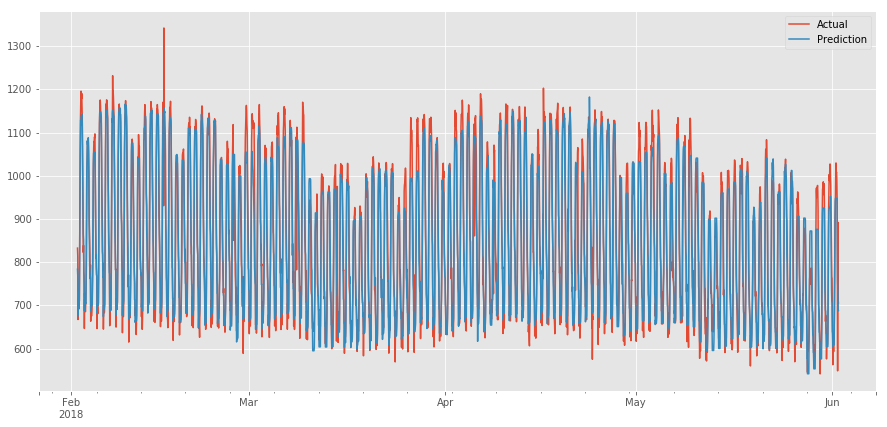

In [48]:
# organize and plot results
results = pd.DataFrame(y_actual,columns=['Actual'])
results['Prediction'] = y_pred
results.plot(figsize=(15,7))

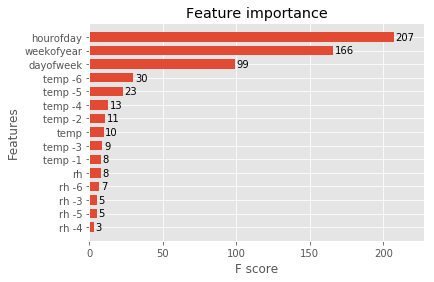

In [49]:
importance = plot_importance(reg, height=0.7,max_num_features=15)